In [2]:
from pathlib import Path
import glob
import exiftool
import soundfile as sf

In [3]:
import numpy as np
import scipy
import pandas as pd
import librosa
import warnings
import os

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [5]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from bat_detect.detector import models
from cfg import get_config
from pipeline import pipeline
from utils.utils import gen_empty_df, convert_df_ravenpro
from bat_detect.utils import wavfile
import bat_detect.utils.detector_utils as du
import bat_detect.detector.compute_features as feats
import bat_detect.detector.post_process as pp

In [6]:
def plot_audio_seg(audio_features, spec_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()


def plot_dets_over_audio(audio_features, spec_features, plot_dets):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()

In [7]:
def load_audio_file(audio_file, time_exp_fact, target_samp_rate, scale=False, max_duration=False):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=wavfile.WavFileWarning)
        #sampling_rate, audio_raw = wavfile.read(audio_file)
        audio_raw, sampling_rate = librosa.load(audio_file, sr=None)

    if len(audio_raw.shape) > 1:
        raise Exception('Currently does not handle stereo files')
    sampling_rate = sampling_rate * time_exp_fact

    # resample - need to do this after correcting for time expansion
    sampling_rate_old = sampling_rate
    sampling_rate = target_samp_rate
    audio_raw = librosa.resample(audio_raw, orig_sr=sampling_rate_old, target_sr=sampling_rate, res_type='polyphase')

    # clipping maximum duration
    if max_duration is not False:
        max_duration = np.minimum(int(sampling_rate*max_duration), audio_raw.shape[0])
        audio_raw = audio_raw[:max_duration]
        
    # convert to float32 and scale
    audio_raw = audio_raw.astype(np.float32)
    if scale:
        audio_raw = audio_raw - audio_raw.mean()
        audio_raw = audio_raw / (np.abs(audio_raw).max() + 10e-6)

    return sampling_rate, audio_raw

In [8]:
input_file1 = Path('../../duty-cycle-investigation/data/audiomoth_recordings/recover-20220822/Telephone/20220820_070000.WAV')

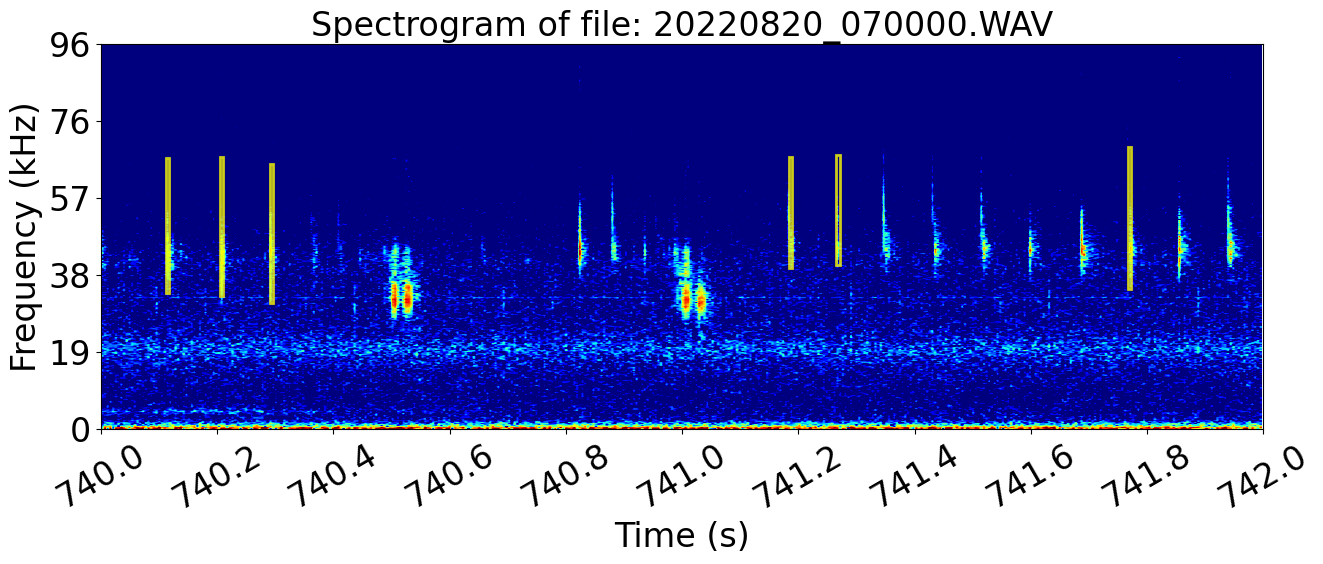

In [9]:
# input_file1 = Path('../../Documents/Research/Lab_related/example/original_recording/recover-20210912_unit2/UBNA_002/20210910_030000.WAV')

cfg = get_config()
cfg['input_audio'] = Path(input_file1)
cfg['tmp_dir'] = Path('../output/tmp')
cfg['output_dir'] = Path('../output_dir/recover-20210912/Foliage/')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = True

filename = input_file1.name.split('.')[0]
original_file_dets = pd.read_csv(f'../../duty-cycle-investigation/data/raw/Telephone/bd2__Telephone_{filename}.csv')
audio_data_original = sf.SoundFile(input_file1)
sampling_rate = audio_data_original.samplerate
start = 740
file_duration = 2
audio_data_original.seek(int(sampling_rate*start))
original_audio_seg = audio_data_original.read(int(sampling_rate*file_duration))

vmin = 20*np.log10(np.max(original_audio_seg)) - 30 # hide anything below -rm_dB dB
vmax = 20*np.log10(np.max(original_audio_seg)) + 0 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = input_file1
audio_features['audio_seg'] = original_audio_seg
audio_features['sample_rate'] = sampling_rate
audio_features['start'] = start
audio_features['duration'] = file_duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax
spec_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name}"

window_cond = np.logical_and(original_file_dets['start_time'] > start, original_file_dets['end_time'] < (start+file_duration))
section_og_file_dets = original_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, section_og_file_dets)

In [83]:
section_og_file_dets

,start_time,end_time,low_freq,high_freq,class,class_prob,det_prob,individual,event,input_file,Recover Folder,SD Card,Site name
891,740.1125,740.1181,34062.0,67747.0,Myotis daubentonii,0.380,0.512,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field
892,740.2045,740.2103,33203.0,67997.0,Myotis daubentonii,0.383,0.521,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field
893,740.2905,740.2956,31484.0,66067.0,Myotis daubentonii,0.441,0.577,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field
894,741.1835,741.1884,40078.0,67795.0,Myotis daubentonii,0.396,0.535,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field
895,741.2655,741.2710,40937.0,68327.0,Myotis daubentonii,0.383,0.547,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field
896,741.7675,741.7728,34921.0,70465.0,Myotis daubentonii,0.382,0.516,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field


In [84]:
resampling_rate, audio_data_resampled = load_audio_file(input_file1, 1, 256000)
audio_data_resampled[int(resampling_rate*start):int(resampling_rate*(start+file_duration))]

array([ 0.0022292 ,  0.00193245, -0.00049695, ..., -0.00431396,
       -0.00365187, -0.0023045 ], dtype=float32)

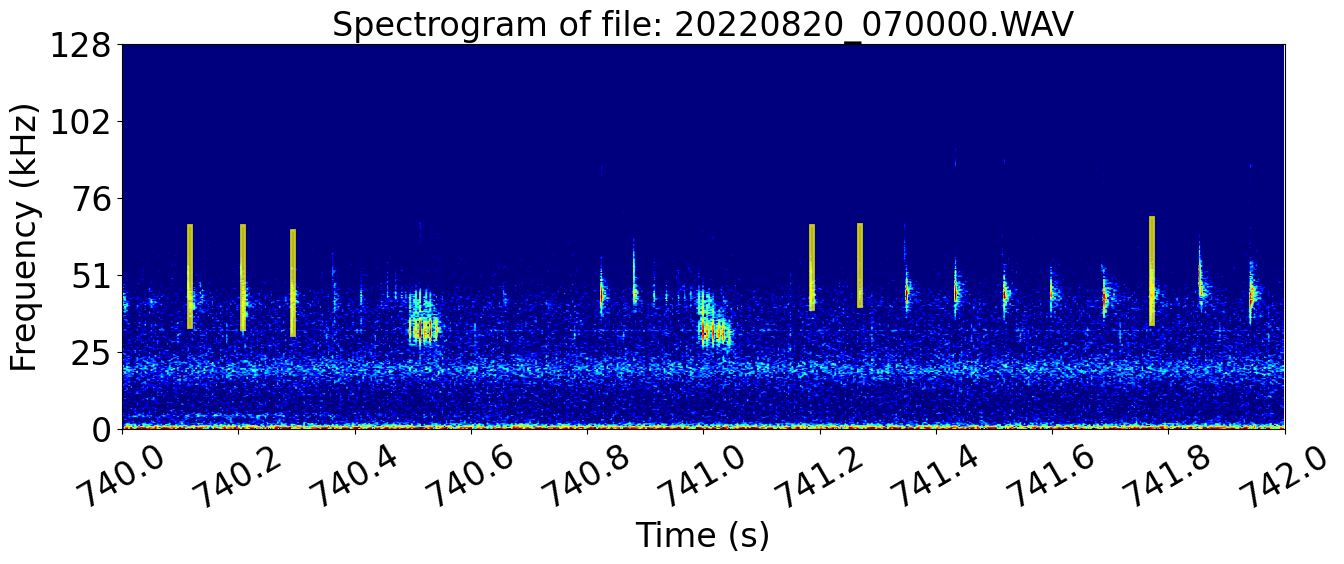

In [86]:
resamp_audio_seg = audio_data_resampled[int(resampling_rate*start):int(resampling_rate*(start+file_duration))]
vmin = 20*np.log10(np.max(resamp_audio_seg)) - 30 # hide anything below -rm_dB dB
vmax = 20*np.log10(np.max(resamp_audio_seg)) + 0 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = input_file1
audio_features['audio_seg'] = resamp_audio_seg
audio_features['sample_rate'] = resampling_rate
audio_features['start'] = start
audio_features['duration'] = file_duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax
spec_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name}"

window_cond = np.logical_and(original_file_dets['start_time'] > start, original_file_dets['end_time'] < (start+file_duration))
section_og_file_dets = original_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, section_og_file_dets)

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_params = torch.load('../src/models/bat_call_detector/batdetect2/models/Net2DFast_UK_same.pth.tar', map_location=device)
params = net_params['params']
params['device'] = device

In [88]:
model = models.Net2DFast(params['num_filters'], num_classes=len(params['class_names']),
                            emb_dim=params['emb_dim'], ip_height=params['ip_height'],
                            resize_factor=params['resize_factor'])
model.load_state_dict(net_params['state_dict'])
model = model.to(params['device'])
model.eval()

Net2DFast(
  (conv_dn_0): ConvBlockDownCoordF(
    (conv): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_dn_1): ConvBlockDownCoordF(
    (conv): Conv2d(33, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_dn_2): ConvBlockDownCoordF(
    (conv): Conv2d(65, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_dn_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_dn_3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1d): Conv2d(256, 256, kernel_size=(16, 1), stride=(1, 1))
  (conv_1d_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a

In [90]:
args = dict()
args['time_expansion_factor'] = 1.0
args['detection_threshold'] = 0.5
args['chunk_size'] = 2
args['spec_slices'] = False
args['quiet'] = False
args['spec_features'] = False
args['cnn_features'] = False

In [91]:
def run_detector_on_audio_data(model, args, params, audio_full, sampling_rate):
    # store temporary results here
    predictions = []
    spec_feats  = []
    cnn_feats   = []
    spec_slices = []

    # get time expansion  factor
    time_exp = args['time_expansion_factor']

    params['detection_threshold'] = args['detection_threshold']
    top_n=5
    # clipping maximum duration
    duration_full = audio_full.shape[0] / float(sampling_rate)

    return_np_spec = args['spec_features'] or args['spec_slices']

    # loop through larger file and split into chunks
    # TODO fix so that it overlaps correctly and takes care of duplicate detections at borders
    num_chunks = int(np.ceil(duration_full/args['chunk_size']))
    for chunk_id in range(num_chunks):

        # chunk
        chunk_time   = args['chunk_size']*chunk_id
        chunk_length = int(sampling_rate*args['chunk_size'])
        start_sample = chunk_id*chunk_length
        end_sample   = np.minimum((chunk_id+1)*chunk_length, audio_full.shape[0])
        audio = audio_full[start_sample:end_sample]

        # load audio file and compute spectrogram
        duration, spec, spec_np = du.compute_spectrogram(audio, sampling_rate, params, return_np_spec)

        # evaluate model
        with torch.no_grad():
            outputs = model(spec, return_feats=args['cnn_features'])

        # run non-max suppression
        pred_nms, features = pp.run_nms(outputs, params, np.array([float(sampling_rate)]))
        pred_nms = pred_nms[0]
        pred_nms['start_times'] += chunk_time
        pred_nms['end_times'] += chunk_time

        # if we have a background class
        if pred_nms['class_probs'].shape[0] > len(params['class_names']):
            pred_nms['class_probs'] = pred_nms['class_probs'][:-1, :]

        predictions.append(pred_nms)

        # extract features - if there are any calls detected
        if (pred_nms['det_probs'].shape[0] > 0):
            if args['spec_features']:
                spec_feats.append(feats.get_feats(spec_np, pred_nms, params))

            if args['cnn_features']:
                cnn_feats.append(features[0])

            if args['spec_slices']:
                spec_slices.extend(feats.extract_spec_slices(spec_np, pred_nms, params))

    # convert the predictions into output dictionary
    file_id = input_file1.name
    predictions, spec_feats, cnn_feats, spec_slices =\
                du.merge_results(predictions, spec_feats, cnn_feats, spec_slices)
    results = du.convert_results(file_id, time_exp, duration_full, params,
                                predictions, spec_feats, cnn_feats, spec_slices)

    # summarize results
    if not args['quiet']:
        num_detections = len(results['pred_dict']['annotation'])
        print('{}'.format(num_detections) + ' call(s) detected above the threshold.')

    # print results for top n classes
    if not args['quiet'] and (num_detections > 0):
        class_overall = pp.overall_class_pred(predictions['det_probs'], predictions['class_probs'])
        print('species name'.ljust(30) + 'probablity present')
        for cc in np.argsort(class_overall)[::-1][:top_n]:
            print(params['class_names'][cc].ljust(30) + str(round(class_overall[cc], 3)))

    annotations = results['pred_dict']['annotation']
    out_df = gen_empty_df()
    if annotations:
        out_df = pd.DataFrame.from_records(annotations) 

    return out_df

In [92]:
sampling_rate = audio_data_original.samplerate
out_df_original = run_detector_on_audio_data(model, args, params, original_audio_seg, sampling_rate)

5 call(s) detected above the threshold.
species name                  probablity present
Myotis daubentonii            0.882
Myotis brandtii               0.075
Myotis mystacinus             0.024
Myotis bechsteinii            0.013
Myotis nattereri              0.003


In [93]:
# store temporary results here
predictions = []
spec_feats  = []
cnn_feats   = []
spec_slices = []

# get time expansion  factor
time_exp = args['time_expansion_factor']

params['detection_threshold'] = args['detection_threshold']
top_n=5
# clipping maximum duration
duration_full = original_audio_seg.shape[0] / float(sampling_rate)

return_np_spec = args['spec_features'] or args['spec_slices']

# loop through larger file and split into chunks
# TODO fix so that it overlaps correctly and takes care of duplicate detections at borders
num_chunks = int(np.ceil(duration_full/args['chunk_size']))
# for chunk_id in range(num_chunks):
chunk_id = 0

# chunk
chunk_time   = args['chunk_size']*chunk_id
chunk_length = int(sampling_rate*args['chunk_size'])
start_sample = chunk_id*chunk_length
end_sample   = np.minimum((chunk_id+1)*chunk_length, original_audio_seg.shape[0])
audio = original_audio_seg[start_sample:end_sample]

# load audio file and compute spectrogram
duration, spec, spec_np = du.compute_spectrogram(audio, sampling_rate, params, return_np_spec)

In [104]:
original_audio_seg.shape

(384000,)

In [105]:
audio.shape

(384000,)

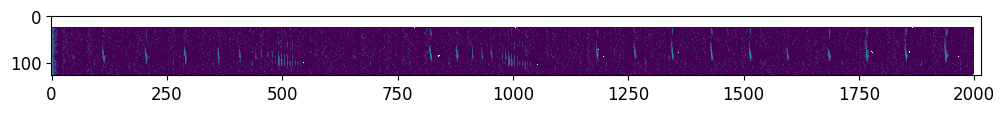

In [97]:
plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size':12})
plt.imshow(spec[0,0,:,:], norm=colors.LogNorm(vmin=0.1, vmax=1e1))
plt.show()

In [106]:
# evaluate model
with torch.no_grad():
    outputs = model(spec, return_feats=args['cnn_features'])
outputs

{'pred_det': tensor([[[[7.5197e-04, 5.0285e-05, 1.6381e-04,  ..., 9.0898e-05,
            2.4239e-04, 4.6792e-04],
           [1.2824e-03, 6.4538e-06, 8.9483e-06,  ..., 4.4200e-05,
            6.3219e-05, 6.5722e-05],
           [1.9421e-02, 1.8601e-04, 6.9611e-05,  ..., 6.3224e-05,
            3.5590e-05, 5.8001e-05],
           ...,
           [2.6325e-03, 1.1665e-03, 1.1938e-03,  ..., 2.6504e-03,
            4.4933e-03, 8.9781e-03],
           [2.8748e-03, 2.4978e-03, 2.7329e-03,  ..., 6.0432e-03,
            8.9649e-03, 1.5684e-02],
           [1.2570e-03, 8.7020e-04, 1.3977e-03,  ..., 3.6254e-03,
            4.0431e-03, 9.6943e-03]]]]),
 'pred_size': tensor([[[[ 8.7607,  9.3682,  8.9079,  ..., 11.1120, 10.9602, 11.4987],
           [ 9.1127, 12.3729, 12.5240,  ..., 10.8333, 10.2234,  9.6978],
           [ 9.9022, 12.9918, 14.3284,  ..., 10.5461, 10.0297,  9.5868],
           ...,
           [ 7.5446,  7.8363,  7.5448,  ...,  7.5435,  7.1657, 10.2974],
           [ 8.5964,  8.9579,

In [107]:
outputs.keys()

dict_keys(['pred_det', 'pred_size', 'pred_class', 'pred_class_un_norm'])

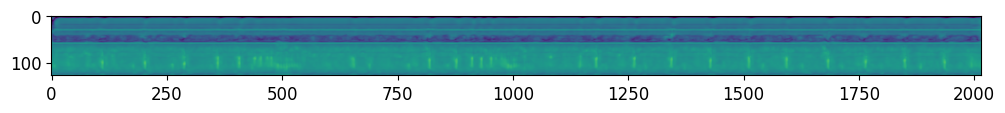

In [108]:
plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size':12})
plt.imshow(outputs['pred_det'][0,0,:,:], norm=colors.LogNorm(vmin=1e-6, vmax=1e2))
plt.show()

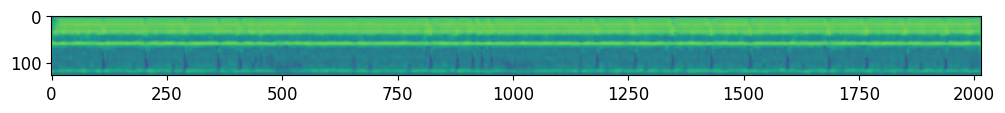

In [109]:
plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size':12})
plt.imshow(outputs['pred_size'][0,0,:,:], norm=colors.LogNorm(vmin=1, vmax=1e2))
plt.show()

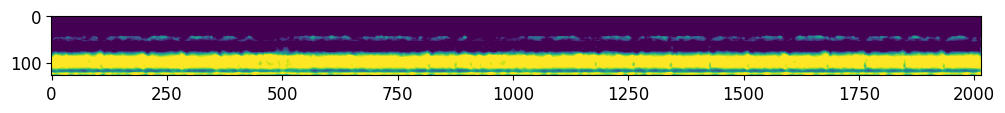

In [110]:
plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size':12})
plt.imshow(outputs['pred_class'][0,0,:,:], norm=colors.LogNorm(vmin=1e-8, vmax=1e-4))
plt.show()

In [111]:
# run non-max suppression
pred_nms, features = pp.run_nms(outputs, params, np.array([float(sampling_rate)]))
pred_nms = pred_nms[0]
pred_nms['start_times'] += chunk_time
pred_nms['end_times'] += chunk_time
pred_nms

{'det_probs': array([0.50362283, 0.5202076 , 0.6010519 , 0.5054564 , 0.53347087],
       dtype=float32),
 'x_pos': array([ 111.,  203.,  289., 1264., 1766.], dtype=float32),
 'y_pos': array([101., 102., 103.,  93.,  99.], dtype=float32),
 'bb_width': array([5.671128 , 5.8879485, 5.140796 , 5.680741 , 5.3140717],
       dtype=float32),
 'bb_height': array([40.79979, 43.24229, 41.29593, 33.04518, 45.15673], dtype=float32),
 'start_times': array([0.1125, 0.2045, 0.2905, 1.2655, 1.7675], dtype=float32),
 'end_times': array([0.11817113, 0.21038796, 0.2956408 , 1.2711809 , 1.7728142 ],
       dtype=float32),
 'low_freqs': array([33203.125, 32343.75 , 31484.375, 40078.125, 34921.875],
       dtype=float32),
 'high_freqs': array([68265.445, 69505.09 , 66973.06 , 68476.33 , 73728.44 ],
       dtype=float32),
 'class_probs': array([[3.1352500e-04, 2.4427520e-04, 1.9538355e-04, 2.9397177e-04,
         4.5912111e-05],
        [1.1615105e-03, 1.3346815e-03, 1.0287117e-03, 5.6309754e-04,
         3.

In [123]:
def merge_results(predictions, spec_feats, cnn_feats, spec_slices):

    predictions_m = {}
    num_preds = np.sum([len(pp['det_probs']) for pp in predictions])

    if num_preds > 0:
        for kk in predictions[0].keys():
            predictions_m[kk] = np.hstack([pp[kk] for pp in predictions if pp['det_probs'].shape[0] > 0])
    else:
        # hack in case where no detected calls as we need some of the key names in dict
        predictions_m = predictions[0]

    if len(spec_feats) > 0:
        spec_feats = np.vstack(spec_feats)
    if len(cnn_feats) > 0:
        cnn_feats = np.vstack(cnn_feats)
    return predictions_m, spec_feats, cnn_feats, spec_slices


def convert_results(file_id, time_exp, duration, params, predictions, spec_feats, cnn_feats, spec_slices):

    # create a single dictionary - this is the format used by the annotation tool
    pred_dict = {}
    pred_dict['id'] = file_id
    pred_dict['annotated'] = False
    pred_dict['issues'] = False
    pred_dict['notes'] = 'Automatically generated.'
    pred_dict['time_exp'] = time_exp
    pred_dict['duration'] = round(duration, 4)
    pred_dict['annotation'] = []

    class_prob_best = predictions['class_probs'].max(0)
    class_ind_best  = predictions['class_probs'].argmax(0)
    class_overall   = pp.overall_class_pred(predictions['det_probs'], predictions['class_probs'])
    pred_dict['class_name'] = params['class_names'][np.argmax(class_overall)]

    for ii in range(predictions['det_probs'].shape[0]):
        res = {}
        res['start_time'] = round(float(predictions['start_times'][ii]), 4)
        res['end_time']   = round(float(predictions['end_times'][ii]), 4)
        res['low_freq']   = int(predictions['low_freqs'][ii])
        res['high_freq']  = int(predictions['high_freqs'][ii])
        res['class']      = str(params['class_names'][int(class_ind_best[ii])])
        res['class_prob'] = round(float(class_prob_best[ii]), 3)
        res['det_prob']   = round(float(predictions['det_probs'][ii]), 3)
        res['individual'] = '-1'
        res['event']      = 'Echolocation'
        pred_dict['annotation'].append(res)

    # combine into final results dictionary
    results = {}
    results['pred_dict'] = pred_dict
    if len(spec_feats) > 0:
        results['spec_feats'] = spec_feats
        results['spec_feat_names'] = feats.get_feature_names()
    if len(cnn_feats) > 0:
        results['cnn_feats'] = cnn_feats
        results['cnn_feat_names'] = [str(ii) for ii in range(cnn_feats.shape[1])]
    if len(spec_slices) > 0:
        results['spec_slices'] = spec_slices

    return results

In [124]:
# if we have a background class
if pred_nms['class_probs'].shape[0] > len(params['class_names']):
    pred_nms['class_probs'] = pred_nms['class_probs'][:-1, :]
pred_nms

{'det_probs': array([0.50362283, 0.5202076 , 0.6010519 , 0.5054564 , 0.53347087],
       dtype=float32),
 'x_pos': array([ 111.,  203.,  289., 1264., 1766.], dtype=float32),
 'y_pos': array([101., 102., 103.,  93.,  99.], dtype=float32),
 'bb_width': array([5.671128 , 5.8879485, 5.140796 , 5.680741 , 5.3140717],
       dtype=float32),
 'bb_height': array([40.79979, 43.24229, 41.29593, 33.04518, 45.15673], dtype=float32),
 'start_times': array([0.1125, 0.2045, 0.2905, 1.2655, 1.7675], dtype=float32),
 'end_times': array([0.11817113, 0.21038796, 0.2956408 , 1.2711809 , 1.7728142 ],
       dtype=float32),
 'low_freqs': array([33203.125, 32343.75 , 31484.375, 40078.125, 34921.875],
       dtype=float32),
 'high_freqs': array([68265.445, 69505.09 , 66973.06 , 68476.33 , 73728.44 ],
       dtype=float32),
 'class_probs': array([[3.1352500e-04, 2.4427520e-04, 1.9538355e-04, 2.9397177e-04,
         4.5912111e-05],
        [1.1615105e-03, 1.3346815e-03, 1.0287117e-03, 5.6309754e-04,
         3.

In [133]:
chunk_results = convert_results(Path(input_file1).name, time_exp, duration_full, params,
                            pred_nms, spec_feats, cnn_feats, spec_slices)
chunk_df = pd.DataFrame.from_records(chunk_results['pred_dict']['annotation'])

In [134]:
chunk_df

,start_time,end_time,low_freq,high_freq,class,class_prob,det_prob,individual,event
0,0.1125,0.1182,33203,68265,Myotis daubentonii,0.452,0.504,-1,Echolocation
1,0.2045,0.2104,32343,69505,Myotis daubentonii,0.478,0.520,-1,Echolocation
2,0.2905,0.2956,31484,66973,Myotis daubentonii,0.541,0.601,-1,Echolocation
3,1.2655,1.2712,40078,68476,Myotis daubentonii,0.420,0.505,-1,Echolocation
4,1.7675,1.7728,34921,73728,Myotis daubentonii,0.457,0.533,-1,Echolocation


In [13]:
audio_data_original = sf.SoundFile(input_file1)
sampling_rate = audio_data_original.samplerate
audio = audio_data_original.read()

In [17]:
audio.shape[0] / sampling_rate

1795.0

In [113]:
predictions.append(pred_nms)

# extract features - if there are any calls detected
if (pred_nms['det_probs'].shape[0] > 0):
    if args['spec_features']:
        spec_feats.append(feats.get_feats(spec_np, pred_nms, params))

    if args['cnn_features']:
        cnn_feats.append(features[0])

    if args['spec_slices']:
        spec_slices.extend(feats.extract_spec_slices(spec_np, pred_nms, params))

In [114]:
predictions

[{'det_probs': array([0.50362283, 0.5202076 , 0.6010519 , 0.5054564 , 0.53347087],
        dtype=float32),
  'x_pos': array([ 111.,  203.,  289., 1264., 1766.], dtype=float32),
  'y_pos': array([101., 102., 103.,  93.,  99.], dtype=float32),
  'bb_width': array([5.671128 , 5.8879485, 5.140796 , 5.680741 , 5.3140717],
        dtype=float32),
  'bb_height': array([40.79979, 43.24229, 41.29593, 33.04518, 45.15673], dtype=float32),
  'start_times': array([0.1125, 0.2045, 0.2905, 1.2655, 1.7675], dtype=float32),
  'end_times': array([0.11817113, 0.21038796, 0.2956408 , 1.2711809 , 1.7728142 ],
        dtype=float32),
  'low_freqs': array([33203.125, 32343.75 , 31484.375, 40078.125, 34921.875],
        dtype=float32),
  'high_freqs': array([68265.445, 69505.09 , 66973.06 , 68476.33 , 73728.44 ],
        dtype=float32),
  'class_probs': array([[3.1352500e-04, 2.4427520e-04, 1.9538355e-04, 2.9397177e-04,
          4.5912111e-05],
         [1.1615105e-03, 1.3346815e-03, 1.0287117e-03, 5.6309754

In [117]:
file_id = os.path.basename(input_file1)
predictions, spec_feats, cnn_feats, spec_slices = merge_results(predictions, spec_feats, cnn_feats, spec_slices)
predictions

{'det_probs': array([0.50362283, 0.5202076 , 0.6010519 , 0.5054564 , 0.53347087],
       dtype=float32),
 'x_pos': array([ 111.,  203.,  289., 1264., 1766.], dtype=float32),
 'y_pos': array([101., 102., 103.,  93.,  99.], dtype=float32),
 'bb_width': array([5.671128 , 5.8879485, 5.140796 , 5.680741 , 5.3140717],
       dtype=float32),
 'bb_height': array([40.79979, 43.24229, 41.29593, 33.04518, 45.15673], dtype=float32),
 'start_times': array([0.1125, 0.2045, 0.2905, 1.2655, 1.7675], dtype=float32),
 'end_times': array([0.11817113, 0.21038796, 0.2956408 , 1.2711809 , 1.7728142 ],
       dtype=float32),
 'low_freqs': array([33203.125, 32343.75 , 31484.375, 40078.125, 34921.875],
       dtype=float32),
 'high_freqs': array([68265.445, 69505.09 , 66973.06 , 68476.33 , 73728.44 ],
       dtype=float32),
 'class_probs': array([[3.1352500e-04, 2.4427520e-04, 1.9538355e-04, 2.9397177e-04,
         4.5912111e-05],
        [1.1615105e-03, 1.3346815e-03, 1.0287117e-03, 5.6309754e-04,
         3.

In [118]:
# results = convert_results(file_id, time_exp, duration_full, params,
#                             predictions, spec_feats, cnn_feats, spec_slices)
pred_dict = {}
pred_dict['id'] = file_id
pred_dict['annotated'] = False
pred_dict['issues'] = False
pred_dict['notes'] = 'Automatically generated.'
pred_dict['time_exp'] = time_exp
pred_dict['duration'] = round(duration, 4)
pred_dict['annotation'] = []

class_prob_best = predictions['class_probs'].max(0)
class_ind_best  = predictions['class_probs'].argmax(0)
class_overall   = pp.overall_class_pred(predictions['det_probs'], predictions['class_probs'])
pred_dict['class_name'] = params['class_names'][np.argmax(class_overall)]

for ii in range(predictions['det_probs'].shape[0]):
    res = {}
    res['start_time'] = round(float(predictions['start_times'][ii]), 4)
    res['end_time']   = round(float(predictions['end_times'][ii]), 4)
    res['low_freq']   = int(predictions['low_freqs'][ii])
    res['high_freq']  = int(predictions['high_freqs'][ii])
    res['class']      = str(params['class_names'][int(class_ind_best[ii])])
    res['class_prob'] = round(float(class_prob_best[ii]), 3)
    res['det_prob']   = round(float(predictions['det_probs'][ii]), 3)
    res['individual'] = '-1'
    res['event']      = 'Echolocation'
    pred_dict['annotation'].append(res)

# combine into final results dictionary
results = {}
results['pred_dict'] = pred_dict
results

{'pred_dict': {'id': '20220820_070000.WAV',
  'annotated': False,
  'issues': False,
  'notes': 'Automatically generated.',
  'time_exp': 1.0,
  'duration': 2.0,
  'annotation': [{'start_time': 0.1125,
    'end_time': 0.1182,
    'low_freq': 33203,
    'high_freq': 68265,
    'class': 'Myotis daubentonii',
    'class_prob': 0.452,
    'det_prob': 0.504,
    'individual': '-1',
    'event': 'Echolocation'},
   {'start_time': 0.2045,
    'end_time': 0.2104,
    'low_freq': 32343,
    'high_freq': 69505,
    'class': 'Myotis daubentonii',
    'class_prob': 0.478,
    'det_prob': 0.52,
    'individual': '-1',
    'event': 'Echolocation'},
   {'start_time': 0.2905,
    'end_time': 0.2956,
    'low_freq': 31484,
    'high_freq': 66973,
    'class': 'Myotis daubentonii',
    'class_prob': 0.541,
    'det_prob': 0.601,
    'individual': '-1',
    'event': 'Echolocation'},
   {'start_time': 1.2655,
    'end_time': 1.2712,
    'low_freq': 40078,
    'high_freq': 68476,
    'class': 'Myotis daube

In [119]:
params

{'data_dir': '/data1/bat_data/data/',
 'ann_dir': '/data1/bat_data/annotations/anns_same/',
 'train_split': 'same',
 'standardize_classs_names_ip': 'Rhinolophus ferrumequinum;Rhinolophus hipposideros',
 'model_name': 'Net2DFast',
 'num_filters': 128,
 'experiment': '../../experiments/2021_12_13__20_20_37/',
 'model_file_name': '../../experiments/2021_12_13__20_20_37/2021_12_13__20_20_37.pth.tar',
 'op_im_dir': '../../experiments/2021_12_13__20_20_37/op_ims/',
 'op_im_dir_test': '../../experiments/2021_12_13__20_20_37/op_ims_test/',
 'notes': '',
 'target_samp_rate': 256000,
 'fft_win_length': 0.002,
 'fft_overlap': 0.75,
 'max_freq': 120000,
 'min_freq': 10000,
 'resize_factor': 0.5,
 'spec_height': 256,
 'spec_train_width': 512,
 'spec_divide_factor': 32,
 'denoise_spec_avg': True,
 'scale_raw_audio': False,
 'max_scale_spec': False,
 'spec_scale': 'pcen',
 'detection_overlap': 0.01,
 'ignore_start_end': 0.01,
 'detection_threshold': 0.5,
 'nms_kernel_size': 9,
 'nms_top_k_per_sec': 2

In [120]:
def gen_empty_df():
    """
    Generates an empty dataframe with the correct columns for the output csv
    """
    return pd.DataFrame({
            "start_time": [],
            "end_time": [],
            "low_freq": [],
            "high_freq": [],
            "event": [],
            "class": [], 
            "class_prob": [],
            "det_prob": [],
            "individual": []
        })

In [121]:
annotations = results['pred_dict']['annotation']
annotations

[{'start_time': 0.1125,
  'end_time': 0.1182,
  'low_freq': 33203,
  'high_freq': 68265,
  'class': 'Myotis daubentonii',
  'class_prob': 0.452,
  'det_prob': 0.504,
  'individual': '-1',
  'event': 'Echolocation'},
 {'start_time': 0.2045,
  'end_time': 0.2104,
  'low_freq': 32343,
  'high_freq': 69505,
  'class': 'Myotis daubentonii',
  'class_prob': 0.478,
  'det_prob': 0.52,
  'individual': '-1',
  'event': 'Echolocation'},
 {'start_time': 0.2905,
  'end_time': 0.2956,
  'low_freq': 31484,
  'high_freq': 66973,
  'class': 'Myotis daubentonii',
  'class_prob': 0.541,
  'det_prob': 0.601,
  'individual': '-1',
  'event': 'Echolocation'},
 {'start_time': 1.2655,
  'end_time': 1.2712,
  'low_freq': 40078,
  'high_freq': 68476,
  'class': 'Myotis daubentonii',
  'class_prob': 0.42,
  'det_prob': 0.505,
  'individual': '-1',
  'event': 'Echolocation'},
 {'start_time': 1.7675,
  'end_time': 1.7728,
  'low_freq': 34921,
  'high_freq': 73728,
  'class': 'Myotis daubentonii',
  'class_prob': 

In [122]:
out_df = pd.DataFrame.from_records(annotations)
out_df

,start_time,end_time,low_freq,high_freq,class,class_prob,det_prob,individual,event
0,0.1125,0.1182,33203,68265,Myotis daubentonii,0.452,0.504,-1,Echolocation
1,0.2045,0.2104,32343,69505,Myotis daubentonii,0.478,0.520,-1,Echolocation
2,0.2905,0.2956,31484,66973,Myotis daubentonii,0.541,0.601,-1,Echolocation
3,1.2655,1.2712,40078,68476,Myotis daubentonii,0.420,0.505,-1,Echolocation
4,1.7675,1.7728,34921,73728,Myotis daubentonii,0.457,0.533,-1,Echolocation


In [37]:
out_df_resampled = run_detector_on_audio_data(model, args, params, resamp_audio_seg, resampling_rate)

71 call(s) detected above the threshold.
species name                  probablity present
Myotis daubentonii            0.375
Pipistrellus nathusii         0.364
Myotis brandtii               0.167
Myotis bechsteinii            0.041
Myotis mystacinus             0.014


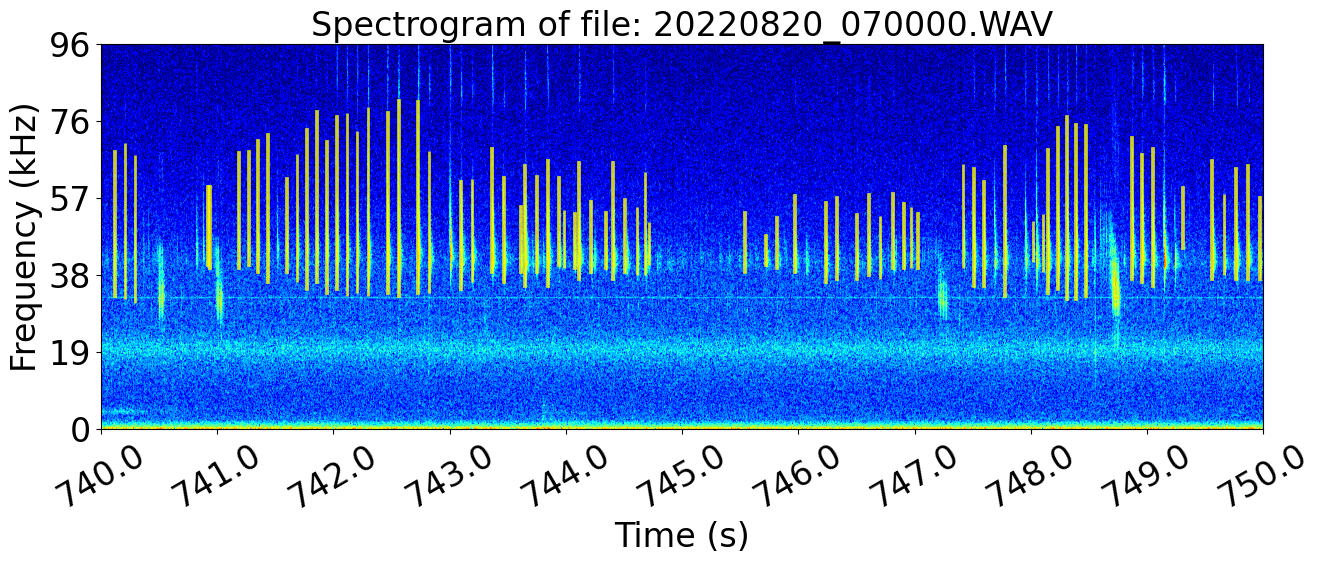

In [38]:
vmax = spec_features['vmax']
vmin = spec_features['vmin']
cmap = spec_features['cmap']
nfft = spec_features['NFFT']

plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 24})
plt.title(spec_features['plot_title'], fontsize=24)
plt.specgram(original_audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

ax = plt.gca()
for i, row in out_df_original.iterrows():
    rect = patches.Rectangle(((row['start_time'])*(sampling_rate/2), row['low_freq']/(sampling_rate/2)), 
                    (row['end_time'] - row['start_time'])*(sampling_rate/2), (row['high_freq'] - row['low_freq'])/(sampling_rate/2), 
                    linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
    ax.add_patch(rect)

plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, sampling_rate/2000, 6).astype('int'))
plot_xtype = 'float'
if (file_duration > 60):
    plot_xtype = 'int'
plt.xticks(ticks=np.linspace(0, file_duration*(sampling_rate/2), 11), 
            labels=np.round(np.linspace(start, start+file_duration, 11, dtype=plot_xtype), 2), rotation=30)
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")
plt.show()

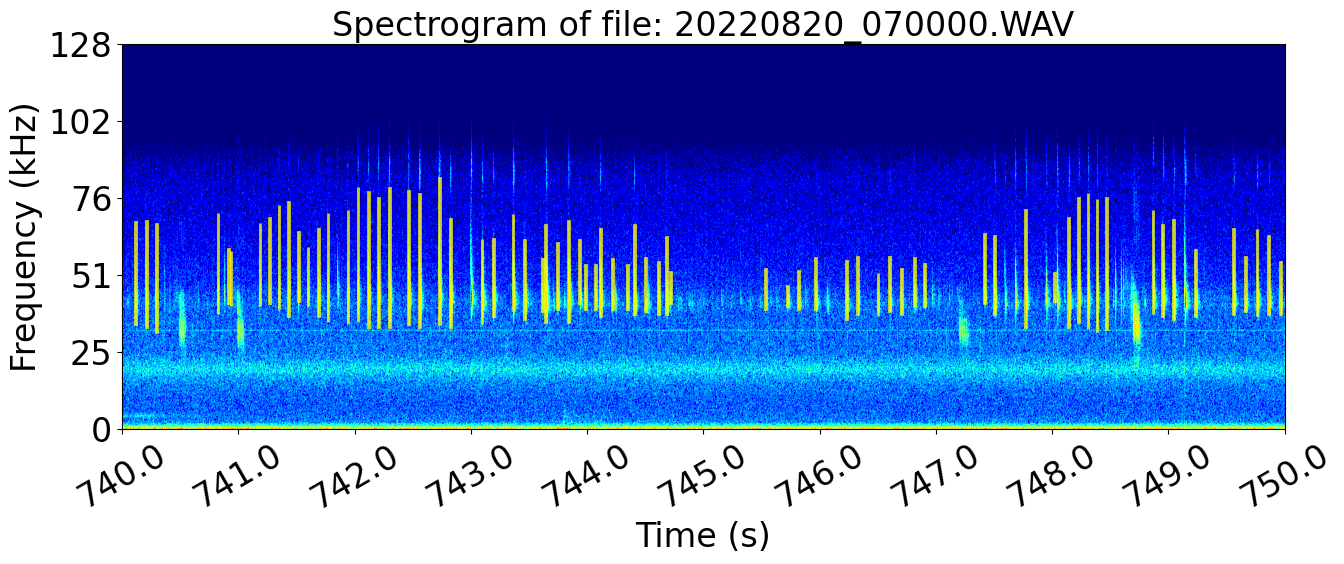

In [39]:
vmax = spec_features['vmax']
vmin = spec_features['vmin']
cmap = spec_features['cmap']
nfft = spec_features['NFFT']

plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 24})
plt.title(spec_features['plot_title'], fontsize=24)
plt.specgram(resamp_audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

ax = plt.gca()
for i, row in out_df_resampled.iterrows():
    rect = patches.Rectangle(((row['start_time'])*(resampling_rate/2), row['low_freq']/(resampling_rate/2)), 
                    (row['end_time'] - row['start_time'])*(resampling_rate/2), (row['high_freq'] - row['low_freq'])/(resampling_rate/2), 
                    linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
    ax.add_patch(rect)

plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, resampling_rate/2000, 6).astype('int'))
plot_xtype = 'float'
if (file_duration > 60):
    plot_xtype = 'int'
plt.xticks(ticks=np.linspace(0, file_duration*(resampling_rate/2), 11), 
            labels=np.round(np.linspace(start, start+file_duration, 11, dtype=plot_xtype), 2), rotation=30)
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")
plt.show()